In [1]:
from openparticle import ParticleOperator
from openparticle.utils import get_fock_basis, generate_matrix
from openparticle.hamiltonians.phi4_hamiltonian import phi4_Hamiltonian
import cirq
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))

from src.lobe.system import System
from src.lobe.lcu import LCU
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, rescale_terms_usp, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes,get_active_bosonic_modes
from src.lobe._utils import get_basis_of_full_system, get_bosonic_exponents, pretty_print
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe.bosonic import bosonic_product_plus_hc_block_encoding, bosonic_modes_block_encoding

from colors import *

In [2]:
def check_unitary(operator, basis, circuit, resolution, max_bosonic_occupancy, system, rescaling_factor):
    if len(circuit.all_qubits()) > 18:
        print("Skipped: ", len(circuit.all_qubits()))

    full_fock_basis = basis
    expected_unitary = generate_matrix(operator, full_fock_basis)

    if len(circuit.all_qubits()) <= 12:
        print("Checking Unitary: ", resolution)
        rescaled_block = circuit.unitary()[:1 << system.number_of_system_qubits, :1 << system.number_of_system_qubits]*rescaling_factor
        if not np.allclose(rescaled_block, expected_unitary):
            print(circuit)
            print(full_fock_basis)
            print("Obtained:\n", rescaled_block.real.round(2))
            print("---")
            print("Expected:\n", expected_unitary.real.round(2))
            assert False
        print("Passed")
    else:
        print(
            f"Testing singular quantum state for circuit with {len(circuit.all_qubits())} qubits"
        )
        simulator = cirq.Simulator()

        zero_state = np.zeros(
            1 << (
                len(circuit.all_qubits())
                - system.number_of_system_qubits
                - 1
            ), dtype=complex,
        )
        zero_state[0] = 1

        initial_control_state = [1, 0]

        random_system_state = np.zeros(1 << system.number_of_system_qubits)
        while np.isclose(np.linalg.norm(expected_unitary @ random_system_state), 0):
            random_system_state = 1j * np.random.uniform(
                -1, 1, 1 << system.number_of_system_qubits
            )
            random_system_state += np.random.uniform(
                -1, 1, 1 << system.number_of_system_qubits
            )
            random_system_state = random_system_state / np.linalg.norm(
                random_system_state
            )

        initial_state = np.kron(np.kron(zero_state, initial_control_state), random_system_state)

        output_state = simulator.simulate(
            circuit, initial_state=initial_state
        ).final_state_vector
        final_state = output_state[: 1 << system.number_of_system_qubits]

        expected_final_state = expected_unitary @ random_system_state
        expected_final_state = expected_final_state / np.linalg.norm(
            expected_final_state
        )
        normalized_final_state = final_state/ np.linalg.norm(final_state)
        if not np.allclose(expected_final_state, normalized_final_state, atol=1e-4):
            print(pretty_print(random_system_state, [system.number_of_system_qubits]))
            print("Failed")
            print(expected_unitary.real.round(2))
            print("Expected", pretty_print(expected_final_state, [system.number_of_system_qubits]))
            print("Obtained", pretty_print(normalized_final_state, [system.number_of_system_qubits]))
            assert False
        print("Passed")

In [19]:
def phi4_lcu_circuit_metrics(resolution, max_bose_occ):
    print("---", resolution, "---")
    operator = operator = phi4_Hamiltonian(resolution, g = 1, mb = 1)
    lcu = LCU(operator, max_bosonic_occupancy=max_bose_occ, zero_threshold=1e-6)

    circuit = lcu.get_circuit()
    system = System(operator.max_bosonic_mode + 1, max_bose_occ, 1000, False, False, True)
    basis = get_fock_basis(operator, max_bose_occ=max_bose_occ)
    print(len(circuit.all_qubits()) > 18)
    check_unitary(operator=operator, basis = basis, circuit=circuit, resolution = resolution, max_bosonic_occupancy=max_bose_occ, system = system, rescaling_factor=lcu.one_norm)
    
    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register), circuit

In [20]:
phi4_lcu_circuit_metrics(4, 3)

--- 4 ---
True
Skipped:  21
Testing singular quantum state for circuit with 21 qubits


KeyboardInterrupt: 

In [8]:
def phi4_LOBE_circuit_metrics(resolution, maximum_occupation_number):
    operator = phi4_Hamiltonian(resolution, 1, 1)


    grouped_terms = operator.group()
    number_of_block_encoding_ancillae = max(
        get_number_of_active_bosonic_modes(grouped_terms)
    )

    index_register = [
        cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(grouped_terms)))))
    ]
    block_encoding_ancillae = [
        cirq.LineQubit(-100 - i - len(index_register))
        for i in range(number_of_block_encoding_ancillae)
    ]
    number_of_block_encoding_ancillae = len(block_encoding_ancillae)
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(
        operator.max_bosonic_mode + 1,
        maximum_occupation_number,
        1000,
        False,
        False,
        True,
    )

    block_encoding_functions = []
    rescaling_factors = []
    for term in grouped_terms:
        plus_hc = False
        if len(term) == 2:
            plus_hc = True
            term = term.to_list()[0]
        active_modes, exponents = get_bosonic_exponents(
            term, operator.max_bosonic_mode + 1
        )

        if not plus_hc:
            block_encoding_functions.append(
                partial(
                    bosonic_modes_block_encoding,
                    system=system,
                    block_encoding_ancillae=block_encoding_ancillae,
                    active_indices=active_modes,
                    exponents_list=exponents,
                    clean_ancillae=clean_ancillae[1:],
                )
            )
            rescaling_factors.append(
                np.sqrt(maximum_occupation_number) ** (sum(sum(np.asarray(exponents))))
            )
        else:
            block_encoding_functions.append(
                partial(
                    bosonic_product_plus_hc_block_encoding,
                    system=system,
                    block_encoding_ancillae=block_encoding_ancillae,
                    active_indices=active_modes,
                    exponents_list=exponents,
                    clean_ancillae=clean_ancillae[1:],
                )
            )
            rescaling_factors.append(
                2
                * np.sqrt(maximum_occupation_number)
                ** (sum(sum(np.asarray(exponents))))
            )

    rescaled_coefficients = []
    for term, rescaling_factor in zip(grouped_terms, rescaling_factors):
        rescaled_coefficients.append(
            term.coeffs[0] * rescaling_factor / max(rescaling_factors)
        )

    target_state = get_target_state(rescaled_coefficients)
    gates = []
    metrics = CircuitMetrics()
    for mode in system.bosonic_system:
        for qubit in mode:
            gates.append(cirq.I.on(qubit))

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(
        index_register, target_state, clean_ancillae=clean_ancillae
    )
    print("Metrics from add_prepare_circuit: \n")
    _metrics.display_metrics()
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(
        index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls
    )
    print("Metrics from index_over_terms: \n")
    _metrics.display_metrics() #Print metrics
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(
        index_register, target_state, dagger=True, clean_ancillae=clean_ancillae
    )
    print("Metrics from add_prepare_circuit: \n")
    _metrics.display_metrics()
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum(
        [
            term.coeffs[0] * rescaling_factor
            for term, rescaling_factor in zip(grouped_terms, rescaling_factors)
        ]
    )
    basis = get_basis_of_full_system(operator.max_bosonic_mode + 1, 
                                               maximum_occupation_number, 
                                               False, False, True)
    print("Total metrics of the block encoding: \n")
    metrics.display_metrics()
    check_unitary(operator, basis, cirq.Circuit(gates), resolution, maximum_occupation_number, system, overall_rescaling_factor)

    return metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_ancillae, cirq.Circuit(gates)


In [9]:
def _get_phi4_hamiltonian_norm(res, max_bose_occ, g=1):
    ham = phi4_Hamiltonian(res, g = g, mb = 1)
    basis = get_fock_basis(ham, max_bose_occ)
    matrix = generate_matrix(ham, basis)


    vals = np.linalg.eigvalsh(matrix)
    return max(np.abs(vals))

In [10]:
omega = 3
resolutions = np.arange(2, 7, 1)
print("LOBE")

GROUPED_LOBE_DATA = [phi4_LOBE_circuit_metrics(res, omega) for res in resolutions]
print("LCU")
LCU_DATA = [phi4_lcu_circuit_metrics(res, omega) for res in resolutions]

operator_norms = []
for res in resolutions:
    operator = phi4_Hamiltonian(res, 1, 1).normal_order()
    operator.remove_identity()
    operator_norms.append(_get_phi4_hamiltonian_norm(res, omega))
    print(res, operator_norms[-1])
system_qubits = [System(phi4_Hamiltonian(res, 1, 1).max_bosonic_mode, omega, 1000, False, False, True).number_of_system_qubits for res in resolutions]

LOBE
Metrics from add_prepare_circuit: 

--- Metrics ---
Number of elbows:  0
Number of T-gates:  0
Number of rotations:  7
---------------
Metrics from index_over_terms: 

--- Metrics ---
Number of elbows:  16
Number of T-gates:  0
Number of rotations:  24
---------------
Metrics from add_prepare_circuit: 

--- Metrics ---
Number of elbows:  0
Number of T-gates:  0
Number of rotations:  7
---------------
Total metrics of the block encoding: 

--- Metrics ---
Number of elbows:  16
Number of T-gates:  0
Number of rotations:  38
---------------
Testing singular quantum state for circuit with 13 qubits
Passed
Metrics from add_prepare_circuit: 

--- Metrics ---
Number of elbows:  0
Number of T-gates:  0
Number of rotations:  15
---------------
Metrics from index_over_terms: 

--- Metrics ---
Number of elbows:  54
Number of T-gates:  0
Number of rotations:  69
---------------
Metrics from add_prepare_circuit: 

--- Metrics ---
Number of elbows:  0
Number of T-gates:  0
Number of rotations: 

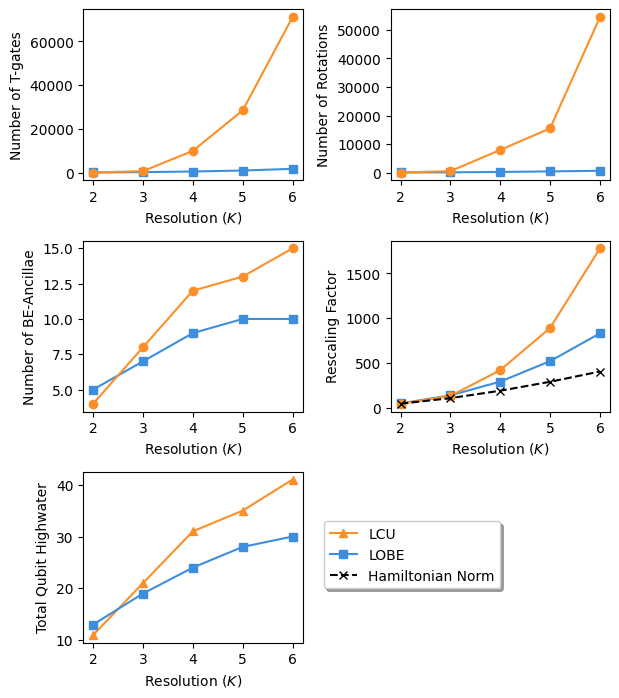

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(16 / 2.54, 18 / 2.54))

axes[0][0].plot(resolutions, [4 * GROUPED_LOBE_DATA[i][0].number_of_elbows for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[0][0].plot(resolutions, [4 * LCU_DATA[i][0].number_of_elbows for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[0][0].set_ylabel("Number of T-gates")
axes[0][0].set_xlabel("Resolution $(K$)")

axes[0][1].plot(resolutions, [GROUPED_LOBE_DATA[i][0].number_of_rotations for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[0][1].plot(resolutions, [LCU_DATA[i][0].number_of_rotations for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[0][1].set_ylabel("Number of Rotations")
axes[0][1].set_xlabel("Resolution $(K$)")

axes[1][0].plot(resolutions, [GROUPED_LOBE_DATA[i][2] for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[1][0].plot(resolutions, [LCU_DATA[i][2] for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[1][0].set_ylabel("Number of BE-Ancillae")
axes[1][0].set_xlabel("Resolution $(K$)")

axes[1][1].plot(resolutions, [GROUPED_LOBE_DATA[i][1] for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label = 'LOBE')
axes[1][1].plot(resolutions, [LCU_DATA[i][1] for i in range(len(resolutions))], color=ORANGE, marker='o', alpha = 1, label = 'LCU')
axes[1][1].plot(resolutions, [operator_norms[i] for i in range(len(resolutions))], color="black", marker='x', ls='--', alpha = 1)
axes[1][1].set_ylabel("Rescaling Factor")
axes[1][1].set_xlabel("Resolution $(K$)")


axes[2][0].plot(resolutions, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + system_qubits[i] + 1 for i in range(len(resolutions))], color=ORANGE, marker='^', alpha = 1, label="LCU")
axes[2][0].plot(resolutions, [GROUPED_LOBE_DATA[i][0].ancillae_highwater() + GROUPED_LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(resolutions))], color=BLUE, marker='s', alpha = 1, label="LOBE")
axes[2][0].plot([], [], color="black", marker='x', ls='--', alpha = 1, label="Hamiltonian Norm")
axes[2][0].set_ylabel("Total Qubit Highwater")
axes[2][0].set_xlabel("Resolution ($K$)")

fig.delaxes(axes[2][1])
plt.tight_layout()
axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
          fancybox=True, shadow=True, ncol=1)
plt.savefig("../manuscript/figures/phi4_resolution_scaling.pdf", dpi=300)

In [16]:
phi4_Hamiltonian(2, 1, 1).group()

[0.23873241463784312 * a1^ a1^ a1 a1,
 1.909859317102745 * a1^ a0^ a1 a0,
 2.432394487827059 * a1^ a1,
 0.9549296585513725 * a0^ a0^ a0 a0,
 4.864788975654118 * a0^ a0]

In [17]:
op = ParticleOperator('a1^ a0 a0')
active_modes, exponents = get_bosonic_exponents(op, 
                                op.max_bosonic_mode + 1)
active_modes, exponents

([1, 0], [(1, 0), (0, 2)])

In [18]:
op = ParticleOperator('a1^ a0 a0')
active_indices = [0, 1]
exponents = [(0, 2), (1, 0)]

max_bose_occ = 3
terms = op.to_list()

bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, max_bose_occ)
coefficients = [term.coeff for term in bosonically_rescaled_terms]

norm = sum(np.abs(coefficients))
target_state = get_target_state(coefficients)
asp_rescaling_factor = (bosonic_rescaling_factor * norm)

number_of_modes = max([term.max_mode for term in terms]) + 1

number_of_ancillae = (
    1000  # Some arbitrary large number with most ancilla disregarded
)
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = len(active_indices)

# Declare Qubits
control = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]

block_encoding_ancillae = [
    cirq.LineQubit(number_of_index_qubits + i + number_of_ancillae)
    for i in range(number_of_rotation_qubits + 1)
] #Index register + rotation qubits

system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=max_bose_occ,
    number_of_used_qubits=1
    + number_of_ancillae
    + number_of_rotation_qubits
    + number_of_index_qubits,
    has_fermions=op.has_fermions,
    has_antifermions=op.has_antifermions,
    has_bosons=op.has_bosons,
)
gates = []
gates.append(cirq.X.on(control))
_gates, metrics = bosonic_product_plus_hc_block_encoding(
    system,
    block_encoding_ancillae,
    active_indices,
    exponents,
    clean_ancillae=clean_ancillae,
    ctrls = ([control], [1])
)
gates += _gates
gates.append(cirq.X.on(control))

Block encoding
 1.0 * a1^ a0 a0
1.0 * a0^ a0^ a1



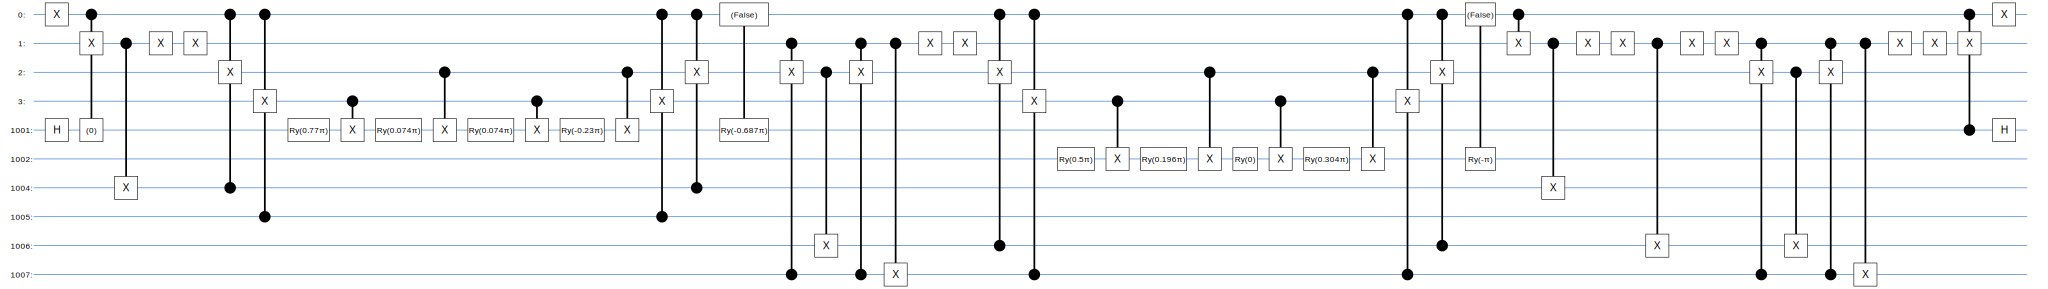

In [19]:
print("Block encoding\n", op + op.dagger())
SVGCircuit(cirq.Circuit(gates))

In [20]:
unitary_rescaling_factor = 2 * np.sqrt(max_bose_occ)**sum(sum(np.asarray(exponents)))

unitary = cirq.Circuit(gates).unitary()[
    :1<<system.number_of_system_qubits, :1<<system.number_of_system_qubits
] * unitary_rescaling_factor

In [21]:
basis_1 = get_fock_basis(op + op.dagger(), max_bose_occ=max_bose_occ)
basis = get_basis_of_full_system(2, max_bose_occ, False, False, True)
matrix = generate_matrix(op + op.dagger(), basis)

In [22]:
np.allclose(unitary, matrix)

True